# Convergence of SIR simulations
I'd like to explore the convergence properties of simulating SIR through an ABM model. Once we have gained an intuition of how the workflow is structure, we'll look into strategies to reduce the time needed for convergence. 

In [1]:
from minigraphs.data import load_graph
from minigraphs.simulation import SIRModel
from mesa.batchrunner import batch_run
from functools import partial

N_STEPS = 80
N_RUNS = 30
BETA = 0.1 
GAMMA = 0.1

params = {
    'beta': BETA,
    'gamma': GAMMA
}

# Load hamsterster graph
graph = load_graph('hamsterster')

# Load graph pool at runtime
graph_pool = [graph]

results_full = batch_run(
    partial(SIRModel, network=graph),
    parameters=params, 
    iterations=N_RUNS,
    max_steps=N_STEPS,
    number_processes=None, 
    data_collection_period=1,
    display_progress=True, 
)

  0%|          | 0/30 [00:00<?, ?it/s]

<Axes: title={'center': 'Compartment=I - N=30'}, xlabel='Step', ylabel='Count'>

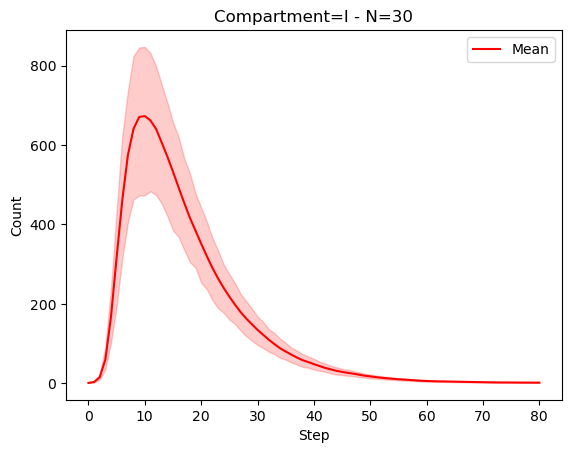

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

def plot_sir(
        data: pd.DataFrame,
        compartment: str = "I",
        linestyle: str = "-",
        full: bool = False
    ):

    iterations = data['iteration'].unique()
    
    # Plot `mean` pandemic
    g = sns.lineplot(
        data,
        x='Step',
        y=compartment,
        color='red',
        label="Mean",
        linestyle=linestyle
    )

    if full:
        # Plot individual runs
        for iteration in iterations:
            label = None if iteration > 0 else "Individual run"

            temp = data[data['iteration'] == iteration]

            g.plot(
                temp['Step'],
                temp[compartment],
                linestyle=':',
                color='r',
                alpha=0.01,
                label=label
            )

    g.set(
        title=f"Compartment={compartment} - N={len(iterations)}",
        ylabel="Count"
    )

    g.legend()
    
    return g

plt.Figure()
plot_sir(pd.DataFrame(results_full))



In [3]:
from minigraphs.sampling import subgraph_metrics
from minigraphs.mcmc.chains import SubgraphUniform
import networkx as nx 
import pandas as pd


n_samples = 100
n_nodes = 200
graph = load_graph('hamsterster')
sizes = [200, 400, 600]


metrics = {
    'clustering': nx.average_clustering,
    'assortativity': nx.degree_assortativity_coefficient
}

df = []
for size in sizes:
    chain = SubgraphUniform(graph, size)

    df.append(subgraph_metrics(chain, n_samples, metrics))

df = pd.concat(df, keys=sizes, names=['size','sample']).reset_index()

100%|██████████| 100/100 [00:03<00:00, 25.20it/s]


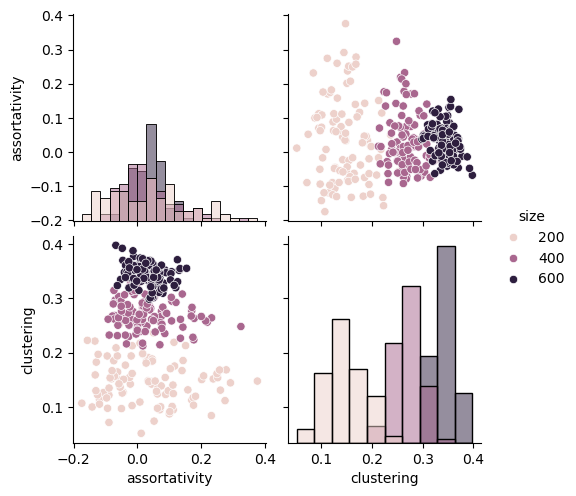

In [4]:
import seaborn as sns 

sns.pairplot(df, hue='size', vars=['assortativity','clustering'], diag_kind='hist')

# Graph Sub-sampling
In order to sample regions of the network that are most favorable, we need to define important metrics that reflect how much we care about a specifi region of the network.

We'll consider the following metrics:
- Spectral radius of the adjacency matrix of a graph $\lambda_1$
- Subgraph boundary size $|B|$
- Algebraic connectivity of the graph $\lambda'_2$

We'll use this metrics to construct an expression that measures the energy of the graphs

$$\mathcal L(G) = -\log \left(\frac{\lambda'_2+\epsilon}{k} \right) - \log \left( \frac{|B|+\epsilon}{k (n-k)}\right) - \log(\lambda_1)$$

## Loss Function Definition

In [5]:
from minigraphs.metrics import laplacian_connectivity, edge_cut_size, graph_spectrum
import networkx as nx 
import numpy as np 
def energy_mixture(
        subgraph: nx.Graph, 
        graph: nx.Graph, 
        epsilon: float=0.01,
    ):

    k = subgraph.number_of_nodes()
    n = graph.number_of_nodes()

    energy = (
        - np.log((laplacian_connectivity(subgraph) + epsilon) / k )
        - np.log((edge_cut_size(graph, subgraph.nodes()) + epsilon)/ (k * (n-k)))
        - np.log((graph_spectrum(subgraph) + epsilon) / k)
    )

    return energy


100%|██████████| 1000/1000 [00:01<00:00, 969.51it/s]


<Axes: >

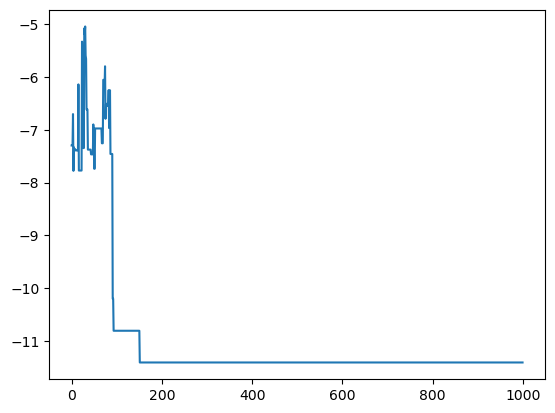

In [7]:
from minigraphs.mcmc import SimulatedAnnealing
from minigraphs.mcmc.chains import SubgraphUniform
from minigraphs.data import load_graph
import seaborn as sns 

# Instantiate a chain
hamsterster_graph = load_graph('hamsterster')

# Instantiate an annealer
annealer = SimulatedAnnealing(
    SubgraphUniform(hamsterster_graph, 200), 
    energy=lambda graph: -graph_spectrum(graph)[0],
    schedule=lambda step: np.exp(step/100),
    max_steps=1000
)

annealer.run()

sns.lineplot(annealer.energies_)

In [10]:
annealer.best_graph_[0]

In [11]:
best_graph = nx.convert_node_labels_to_integers(annealer.best_graph_[0])

results_mini = batch_run(
    partial(SIRModel, network=best_graph),
    parameters=params, 
    iterations=N_RUNS,
    max_steps=N_STEPS,
    number_processes=None, 
    data_collection_period=1,
    display_progress=True, 
)

  0%|          | 0/30 [00:00<?, ?it/s]

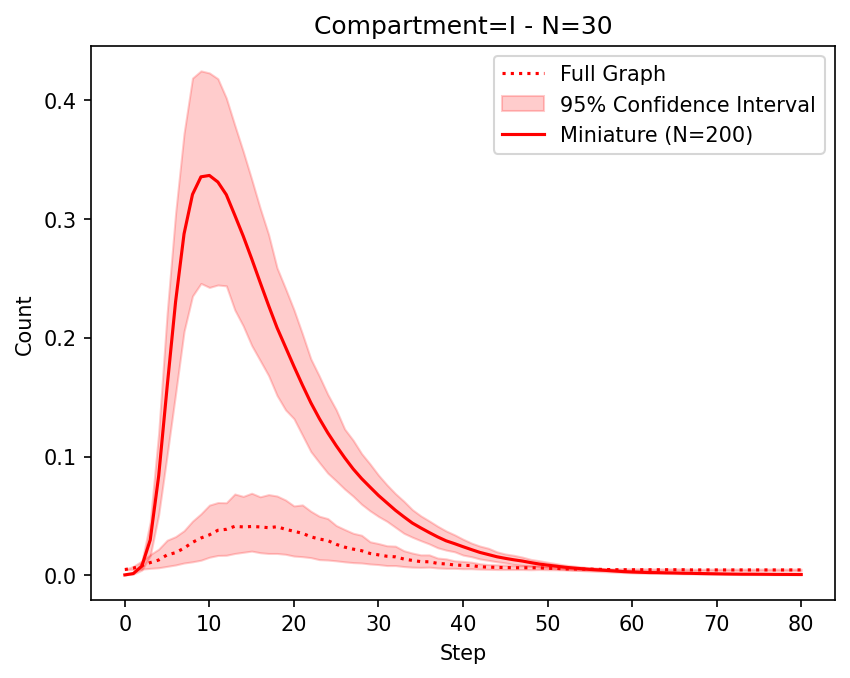

In [12]:
fig, ax = plt.subplots(dpi=150)

df_mini = pd.DataFrame(results_mini)
df_mini['I'] = df_mini['I'] / 200

df_full = pd.DataFrame(results_full)
df_full['I'] = df_full['I'] / 2000

plot_sir(df_mini, linestyle=':')
plot_sir(df_full)

plt.legend(["Full Graph", "95% Confidence Interval", "Miniature (N=200)"])


## Visualizing the subgraphs

First, we compute the layout of the graph using the ForceAtlas2 algorithm.

In [86]:
layout = nx.forceatlas2_layout(graph, max_iter=200)

In [115]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
from matplotlib.colors import LogNorm
import numpy as np

def plot_node_participation(
    G: nx.Graph,
    layout: dict,
    subgraphs: list[nx.Graph],
    ax: plt.Axes = None,
    cmap: str = 'viridis'
):
    """
    Plots the graph with nodes colored by their frequency of appearance
    across a list of subgraphs.

    Parameters
    ----------
    G : nx.Graph
        The full graph.
    layout : dict
        A dict mapping nodes to positions (e.g., from nx.spring_layout).
    subgraphs : list of nx.Graph
        The list of subgraphs (each a subset of G) whose node appearances will be counted.
    ax : plt.Axes, optional
        The matplotlib axis to draw on.
    cmap : str
        Colormap name to use for node coloring.

    Returns
    -------
    matplotlib.collections.PathCollection
        The node collection created by networkx.draw_networkx_nodes
    """
    # Count node occurrences
    count = Counter()
    for sg in subgraphs:
        count.update(list(sg.nodes))

    # Convert to array with ordering matching G.nodes
    nodes = list(G.nodes)
    values = np.array([count[n] for n in nodes])

    # Normalize values for coloring
    if np.max(values) > 0:
        norm_values = values / np.max(values)
    else:
        norm_values = values

    # Prepare plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Draw nodes and edges
    node_collection = nx.draw_networkx_nodes(
        G, 
        pos=layout, 
        node_color=norm_values,
        alpha=norm_values,
        cmap=plt.get_cmap(cmap), 
        ax=ax, 
        node_size=5
    )
    nx.draw_networkx_edges(G, pos=layout, ax=ax, alpha=0.1)

    # Optionally: add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=1.0, vmax=np.max(values), clip=True))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Node participation count')

    ax.set_title(f'Node appearance frequency in sampled subgraphs')
    ax.set_axis_off()

    return node_collection


In [114]:
layout = nx.forceatlas2_layout(hamsterster_graph, max_iter=300)

/Users/joy/miniforge3/envs/minigraphs/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


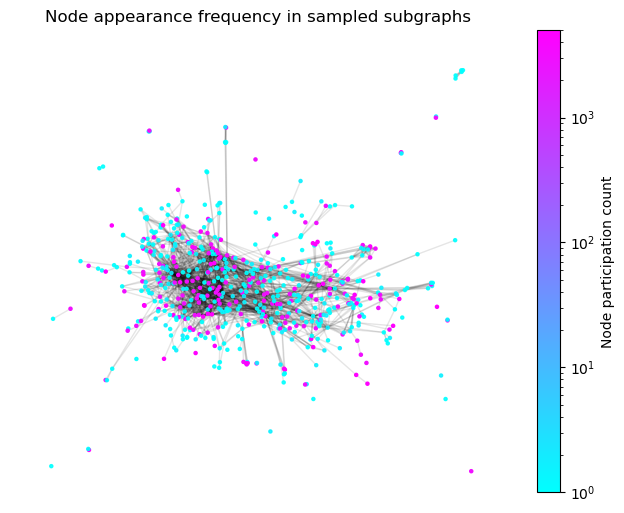

In [116]:
plot_node_participation(graph, layout, list(annealer.samples)[-5000:], cmap='cool')